# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

## Step 1: Load the python libraries that you will need for this project 

In [198]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
import seaborn as sns
%matplotlib inline

# Step 2: Examine your data 

#### Exploring Aiport_Cancelations.csv

In [199]:
cancelations = pd.read_csv("/Users/Paul/Desktop/General_Assembly/DSI_SM_01/projects/01-projects-weekly/project-07/assets/airport_cancellations.csv")

In [200]:
# check the shape of dataframe
cancelations.shape

(805, 6)

#### Exploring Airports.csv

In [201]:
airports = pd.read_csv('/Users/Paul/Desktop/General_Assembly/DSI_SM_01/projects/01-projects-weekly/project-07/assets/airports.csv')

In [202]:
airports.shape

(5167, 13)

### Prepare and Merge DataFrames

In [203]:
# turn year into int
cancelations.Year = cancelations.Year.astype(int)

#### Create a list of unique Airport Keys from Cancelation data

In [204]:
# create a list of unique aiport codes to use in next step
cancel_airports_list = cancelations['Airport'].unique()

In [205]:
cancel_airports_list

array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN',
       'DFW', 'DTW', 'EWR', 'FLL', 'HNL', 'HOU', 'HPN', 'IAD', 'IAH',
       'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB', 'MCI',
       'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK',
       'OGG', 'OMA', 'ONT', 'ORD', 'OXR', 'PBI', 'PDX', 'PHL', 'PHX',
       'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW', 'SAN', 'SAT', 'SDF',
       'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'SWF',
       'TPA', 'TUS'], dtype=object)

In [206]:
# loop through list of airport id's from cancelations
airportsDF = airports[airports['LocID'].isin([i for i in cancel_airports_list])]

In [207]:
airportsDF.head(1)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
10,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes


In [208]:
airportsDF.isnull().sum()

Key                        0
LocID                      0
AP_NAME                    0
ALIAS                      0
Facility Type              0
FAA REGION                 0
COUNTY                     0
CITY                       0
STATE                      0
AP Type                    0
Latitude                   0
Longitude                  0
Boundary Data Available    0
dtype: int64

In [209]:
# rename so columns can merge
airportsDF.rename(columns={'LocID': 'Airport'}, inplace=True)

In [211]:
#airportsDF.tail(2)

#### Merge!

In [212]:
# merge on only matching key value which is Airport
combined = pd.merge(airportsDF, cancelations)

In [213]:
# check nulls
combined.isnull().sum()

Key                        0
Airport                    0
AP_NAME                    0
ALIAS                      0
Facility Type              0
FAA REGION                 0
COUNTY                     0
CITY                       0
STATE                      0
AP Type                    0
Latitude                   0
Longitude                  0
Boundary Data Available    0
Year                       0
Departure Cancellations    0
Arrival Cancellations      0
Departure Diversions       0
Arrival Diversions         0
dtype: int64

### Data Junky? Data Junky! i can haz more data? 

In [219]:
# load in some more data...
ops = pd.read_csv('/Users/Paul/Desktop/General_Assembly/DSI_SM_01/projects/01-projects-weekly/project-07/assets/Airport_operations.csv')

In [220]:
ops.head(1)

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87


In [221]:
ops.shape

(841, 15)

### Merge new Data with Combined for Master DataFrame!

In [222]:
# rename so columns can merge
ops.rename(columns={'airport': 'Airport','year': 'Year' }, inplace=True)

In [227]:
# create a master data set with all values in one place

master = pd.merge(combined, ops, how = 'left', on=['Airport', 'Year'])

In [228]:
master.shape

(805, 31)

In [229]:
master.isnull().sum()

Key                                   0
Airport                               0
AP_NAME                               0
ALIAS                                 0
Facility Type                         0
FAA REGION                            0
COUNTY                                0
CITY                                  0
STATE                                 0
AP Type                               0
Latitude                              0
Longitude                             0
Boundary Data Available               0
Year                                  0
Departure Cancellations               0
Arrival Cancellations                 0
Departure Diversions                  0
Arrival Diversions                    0
departures for metric computation     6
arrivals for metric computation       6
percent on-time gate departures       6
percent on-time airport departures    6
percent on-time gate arrivals         6
average_gate_departure_delay          6
average_taxi_out_time                 6


#### Fill Missing Values with Average Values of what data is available based on Airport

In [230]:
# missing values for Sac and Palm Spirngs 2004-2006 - 6 rows... leave alone or fill... 
# let's fill them with the average values we have for the other years

# take column from master with null values and fill with a grouped mean value of the remaining available data on the airport 
master['departures for metric computation'] = master.groupby(['Airport'])['departures for metric computation'].transform(lambda x: x.fillna(x.mean()))
master['arrivals for metric computation'] = master.groupby(['Airport'])['arrivals for metric computation'].transform(lambda x: x.fillna(x.mean()))
master['percent on-time gate departures'] = master.groupby(['Airport'])['percent on-time gate departures'].transform(lambda x: x.fillna(x.mean()))
master['percent on-time airport departures'] = master.groupby(['Airport'])['percent on-time airport departures'].transform(lambda x: x.fillna(x.mean()))
master['percent on-time gate arrivals'] = master.groupby(['Airport'])['percent on-time gate arrivals'].transform(lambda x: x.fillna(x.mean()))
master['average_taxi_out_time'] = master.groupby(['Airport'])['average_taxi_out_time'].transform(lambda x: x.fillna(x.mean()))
master['average taxi out delay'] = master.groupby(['Airport'])['average taxi out delay'].transform(lambda x: x.fillna(x.mean()))
master['average airport departure delay'] = master.groupby(['Airport'])['average airport departure delay'].transform(lambda x: x.fillna(x.mean()))
master['average_gate_departure_delay'] = master.groupby(['Airport'])['average_gate_departure_delay'].transform(lambda x: x.fillna(x.mean()))
master['average airborne delay'] = master.groupby(['Airport'])['average airborne delay'].transform(lambda x: x.fillna(x.mean()))
master['average taxi in delay'] = master.groupby(['Airport'])['average taxi in delay'].transform(lambda x: x.fillna(x.mean()))
master['average block delay'] = master.groupby(['Airport'])['average block delay'].transform(lambda x: x.fillna(x.mean()))
master['average gate arrival delay'] = master.groupby(['Airport'])['average gate arrival delay'].transform(lambda x: x.fillna(x.mean()))

In [231]:
# no more nulls!
master.isnull().sum()

Key                                   0
Airport                               0
AP_NAME                               0
ALIAS                                 0
Facility Type                         0
FAA REGION                            0
COUNTY                                0
CITY                                  0
STATE                                 0
AP Type                               0
Latitude                              0
Longitude                             0
Boundary Data Available               0
Year                                  0
Departure Cancellations               0
Arrival Cancellations                 0
Departure Diversions                  0
Arrival Diversions                    0
departures for metric computation     0
arrivals for metric computation       0
percent on-time gate departures       0
percent on-time airport departures    0
percent on-time gate arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0


In [232]:
# export to csv

master.to_csv('MASTERProject7.csv')

### Intro: Write a problem statement / aim for this project

We want to understand the behavior of flight cancellations
Answer: 

First, I'm going to drop Years because we're going to look at airports overall performance regarldess of time of year. 

#### 1.2 What are the risks and assumptions of our data? 

### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [234]:
master.head(1)

,Key,Airport,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,...,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,2885.0,SJU,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,...,0.7794,0.7984,11.19,13.84,2.27,12.43,1.88,0.79,3.39,12.28


In [236]:
FAA_region_on_time = master[['FAA REGION','percent on-time gate departures','percent on-time airport departures','percent on-time gate arrivals','average_taxi_out_time']]

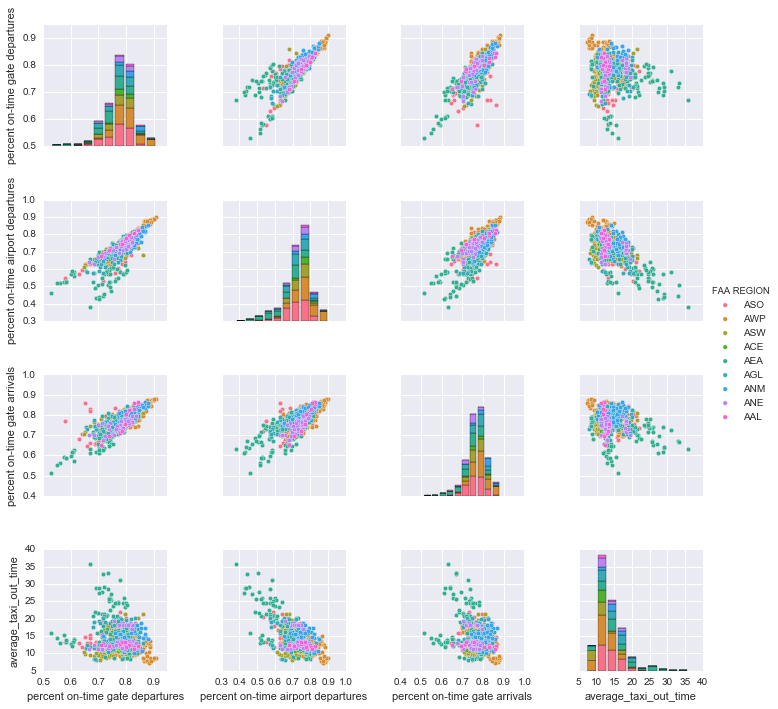

In [238]:
sns.set()
sns.pairplot(FAA_region_on_time, hue="FAA REGION")

In [55]:
percent_on_time = overallOperations[['airport','percent on-time gate departures','percent on-time airport departures','percent on-time gate arrivals','average_taxi_out_time']]

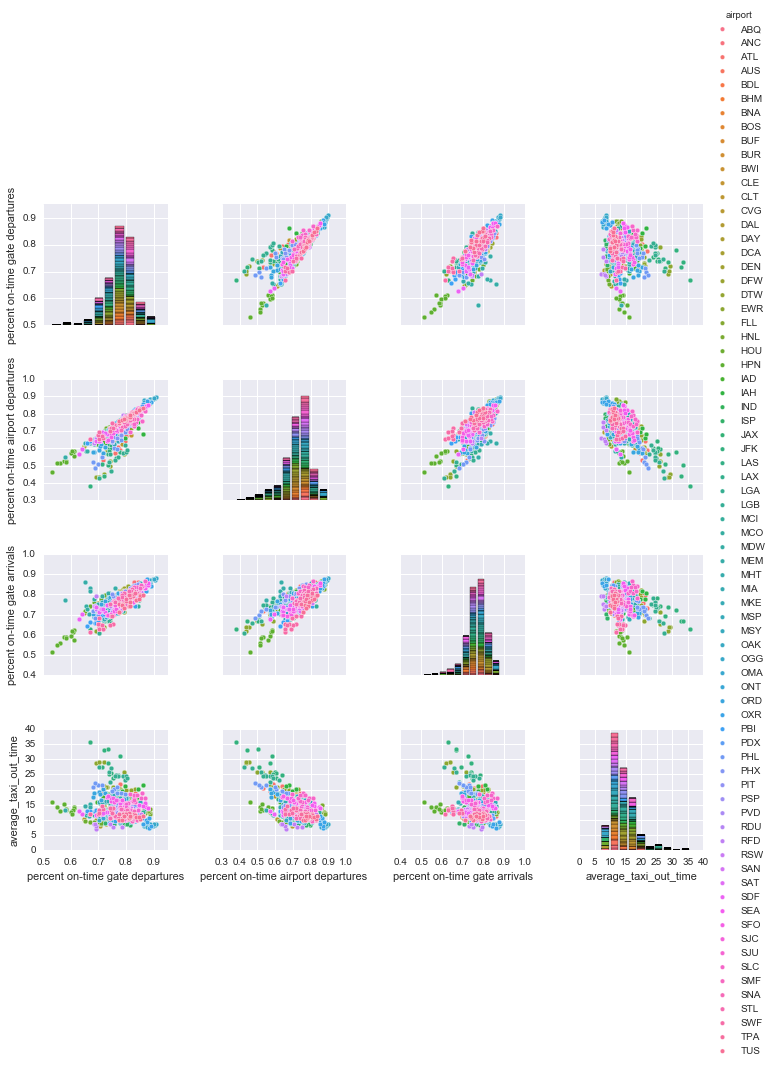

In [56]:
sns.set()
sns.pairplot(percent_on_time, hue="airport")

In [ ]:
percent_on_time = overallOperations[['airport','percent on-time gate departures','percent on-time airport departures','percent on-time gate arrivals','average_taxi_out_time']]

#### Are there any unique values? 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

#### 3.2 Format and Clean the Data

### Part 4: Define the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

#### 4.2 Find correlations in the data

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: 

#### 4.4 Validate your findings using statistical analysis

#### 4.5 How can you improve your overall analysis? 

Answer: 

### Part 5: Perform a PCA and Present Findings

#### 5.1 Conduct the PCA

In [ ]:
# Create a clean data frame 
ap1 = ap[['airport','year','departure cancellations','arrival cancellations']]
print ap1.head()

#### 5.2 Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps

### Part 6: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied

In [ ]:
# for merging

In [ ]:
# turn year into int
cancelations.Year = cancelations.Year.astype(int)